In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import glob


#path
BASE = '/scratch/ab10313/pleiades/'

PATH_NN = BASE+'NN_data_new/'
#os.mkdir(PATH_NN)

PATH_LIST_all = glob.glob(BASE+'*/preprcossed_data/')
PATH_LIST_full_smooth = glob.glob(BASE+'*_smooth/preprcossed_data/')
PATH_LIST_full = [i for i in PATH_LIST_all if i not in PATH_LIST_full_smooth]

In [2]:
PATH_LIST_full

['/scratch/ab10313/pleiades/10_north_pacific/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean/preprcossed_data/',
 '/scratch/ab10313/pleiades/15_bengal/preprcossed_data/']

In [9]:
# function that splits datasets along the spacial axes and concats them back into single array under time

def normalize(data):
    normalized_data =  (data - np.nanmean(data))/np.nanstd(data)
    return normalized_data

def smooth(data,time_window, coarsen_factor):
    if len(data.dims) == 3:
        smoothed_data = data.rolling(time=time_window, center=True).mean().dropna(dim="time", how="all").coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean()
    elif len(data.dims) == 2:
        smoothed_data = np.tile(data.coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean(),(846,1,1))
    return smoothed_data


def load_data_norm(var_name_string,time_window=15,coarsen_factor=12):
    PATH_LIST_all = glob.glob(BASE+'*/preprcossed_data/')
    PATH_LIST_full_smooth = glob.glob(BASE+'*_smooth/preprcossed_data/')
    PATH_LIST = [i for i in PATH_LIST_all if i not in PATH_LIST_full_smooth] 
    data_0 = xr.open_dataarray(PATH_LIST[0])
    data_smooth_0 = smooth(data_0,time_window,coarsen_factor)
    data_smooth_norm_0 = normalize(data_smooth_0)
    data_app = data_smooth_norm_0
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_smooth = smooth(data,time_window,coarsen_factor)
        data_smooth_norm = normalize(data_smooth)
        data_app = np.concatenate((data_app,data_smooth_norm),axis=0)
    return data_app


def load_data(var_name_string,time_window=15,coarsen_factor=12):
    PATH_LIST_all = glob.glob(BASE+'*/preprcossed_data/')
    PATH_LIST_full_smooth = glob.glob(BASE+'*_smooth/preprcossed_data/')
    PATH_LIST = [i for i in PATH_LIST_all if i not in PATH_LIST_full_smooth] 
    data_0 = xr.open_dataarray(PATH_LIST[0])
    data_smooth_0 = smooth(data_0,time_window,coarsen_factor)
    data_app = data_smooth_0
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_smooth = smooth(data,time_window,coarsen_factor)
        data_app = np.concatenate((data_app,data_smooth),axis=0)
    return data_app

def FK_param(PATH,time_window=15,coarsen_factor=12):
    # FK08 parameterization inputs
    tau = 86400
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)
    B_x = smooth(xr.open_dataarray(PATH+'B_x.nc'),time_window,coarsen_factor).values
    B_y = smooth(xr.open_dataarray(PATH+'B_y.nc'),time_window,coarsen_factor).values
    grad_B = np.sqrt(B_y**2 + B_x**2)
    
    HML = smooth(xr.open_dataarray(PATH+'HML.nc'),time_window,coarsen_factor).values
    Nsquared = smooth(xr.open_dataarray(PATH+'Nsquared.nc'),time_window,coarsen_factor).values
    
    WB_FK = ((HML**2) * (grad_B**2))/np.abs(FCOR**2 + tau**-2)
    WB_FK_norm = normalize(WB_FK)
    
    # WB FK11 with Lf rescaling factor
   # ds = 25e3 # approx 1/4 degree resolution  ~ 25km
   # Lf = (np.sqrt(np.abs(Nsquared))*HML)/np.sqrt(FCOR**2 + tau**-2)

   # WB_FK_Lf = (ds /Lf)*((HML**2) * (grad_B**2))/np.sqrt(FCOR**2 + tau**-2)
   # WB_FK_Lf_norm = normalize(WB_FK_Lf)
    return WB_FK_norm
    
    
def load_data_FK(time_window=15,coarsen_factor=12):
    PATH_LIST_all = glob.glob(BASE+'*/preprcossed_data/')
    PATH_LIST_full_smooth = glob.glob(BASE+'*_smooth/preprcossed_data/')
    PATH_LIST_full = [i for i in PATH_LIST_all if i not in PATH_LIST_full_smooth] 
    WB_FK_norm_0 = FK_param(PATH_LIST_full[0])
    data_app = WB_FK_norm_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_FK_norm = FK_param(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_FK_norm),axis=0)
    return data_app
    
    
def WB_sg(PATH,time_window=15,coarsen_factor=12):
    # WB
    B = smooth(xr.open_dataarray(PATH+'B.nc'),time_window,coarsen_factor).values
    W = smooth(xr.open_dataarray(PATH+'W.nc'),time_window,coarsen_factor).values
    WB = smooth(xr.open_dataarray(PATH+'WB.nc'),time_window,coarsen_factor).values
    
    # WB subgrid
    WB_sg = WB - W*B
    WB_sg_norm = normalize(WB_sg)

    return WB_sg_norm


    
def load_data_WB(time_window=15,coarsen_factor=12):
    PATH_LIST_all = glob.glob(BASE+'*/preprcossed_data/')
    PATH_LIST_full_smooth = glob.glob(BASE+'*_smooth/preprcossed_data/')
    PATH_LIST_full = [i for i in PATH_LIST_all if i not in PATH_LIST_full_smooth] 
    WB_sg_norm_0 = WB_sg(PATH_LIST_full[0])
    data_app = WB_sg_norm_0
    for i_file in np.arange(1,len(PATH_LIST_full)):
        WB_sg_norm = FK_param(PATH_LIST_full[i_file])
        data_app = np.concatenate((data_app,WB_sg_norm),axis=0)
    return data_app

In [10]:
WB_FK = load_data_FK()

WB_sg = load_data_WB()

In [11]:
WB_FK.shape

(8460, 40, 40)

In [12]:
# load FK08 variables relevant for w'b' parameterization:
FCOR = load_data_norm('FCOR') 
B_x = load_data_norm('B_x') 
B_y = load_data_norm('B_y')
grad_B = np.sqrt(B_y**2 + B_x**2)

HML = load_data_norm('HML') 
Nsquared = load_data_norm('Nsquared')


/ext3/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/ext3/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/ext3/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/ext3/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:126: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/ext3/miniconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:126: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/ext3/miniconda3/lib/python3.9/site-pack

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
# load other variables that may be relevant for w'b':

U = load_data_norm('U') 
V = load_data_norm('V') 

TAUX = load_data_norm('TAUX') 
TAUY = load_data_norm('TAUY')
TAU = np.sqrt(TAUY**2 + TAUX**2)

Q = load_data_norm('Q')
HBL = load_data_norm('HBL')


In [ ]:
# save normalized NN data

np.save(PATH_NN+'grad_B.npy',grad_B)
np.save(PATH_NN+'FCOR.npy',FCOR)
np.save(PATH_NN+'WB_sg.npy',WB_sg)
np.save(PATH_NN+'WB_FK.npy',WB_FK)
np.save(PATH_NN+'HML.npy',HML)

np.save(PATH_NN+'TAU.npy',TAU)
np.save(PATH_NN+'U.npy',U)
np.save(PATH_NN+'V.npy',V)
np.save(PATH_NN+'Q.npy',Q)
np.save(PATH_NN+'HBL.npy',HBL)
np.save(PATH_NN+'FCOR.nc',FCOR)

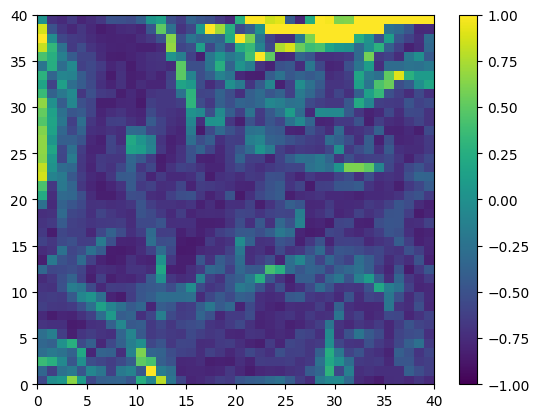

In [103]:
plt.pcolor(grad_B_norm[1400],vmin=-1,vmax=1)
plt.colorbar()